Overview
 
This challenge is part of the "2024 Kaggle Playground Series". These competitions use synthetic data, so it is expected that some noise generated during data creation will impact overall model quality.

Goal: Predict the probability of various defects on steel plates.


Approach: In this notebook I used combined the predictions of a keras.sequential neural network and a XGBoost decision tree. However, on average, individual XGBoost models performed better than keras NNs (approx. 2% higher AUC). Regarding feature engineering, I found that squaring the ['Length_of_Conveyer'] a signficant improvement in competition metric.

# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import torch

pd.set_option('display.max_columns', None)

2024-03-31 14:18:02.734993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 14:18:02.735091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 14:18:02.879001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Load train and test data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

In [3]:
print('Number of missing values:', train_df.columns.isna().sum())
print(train_df.shape)
train_df.head()

Number of missing values: 0
(19219, 35)


,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


# EDA

In [4]:
train_df['outcome_sum'] = train_df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].sum(axis=1)
train_df.head()
train_df['outcome_sum'].value_counts()

outcome_sum
1    18380
0      818
2       21
Name: count, dtype: int64

In [5]:
train_df_exp = train_df.copy()

In [6]:
train_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,outcome_sum
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,128.647380,1459.350747,0.402674,0.596337,76.213122,0.352939,0.409309,0.574520,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225,0.958531
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,14.196976,145.568687,0.490449,0.490644,53.931960,0.318976,0.124143,0.259436,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133,0.204786
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,39.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.317500,0.375750,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413500,0.545400,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.656100,0.494600,0.818200,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.927500,1.000000,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [7]:
# Define the function to categorize outcomes
def categorize_outcome(row):
    if row['outcome_sum'] == 0:
        return 'None'
    elif row['outcome_sum'] == 1:
        # Find the column name where the value is 1
        return row[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].idxmax()
    else:
        return 'Mixed'



# Apply the function row-wise to create the new variable
train_df_exp['new_variable'] = train_df_exp.apply(categorize_outcome, axis=1)

<Axes: >

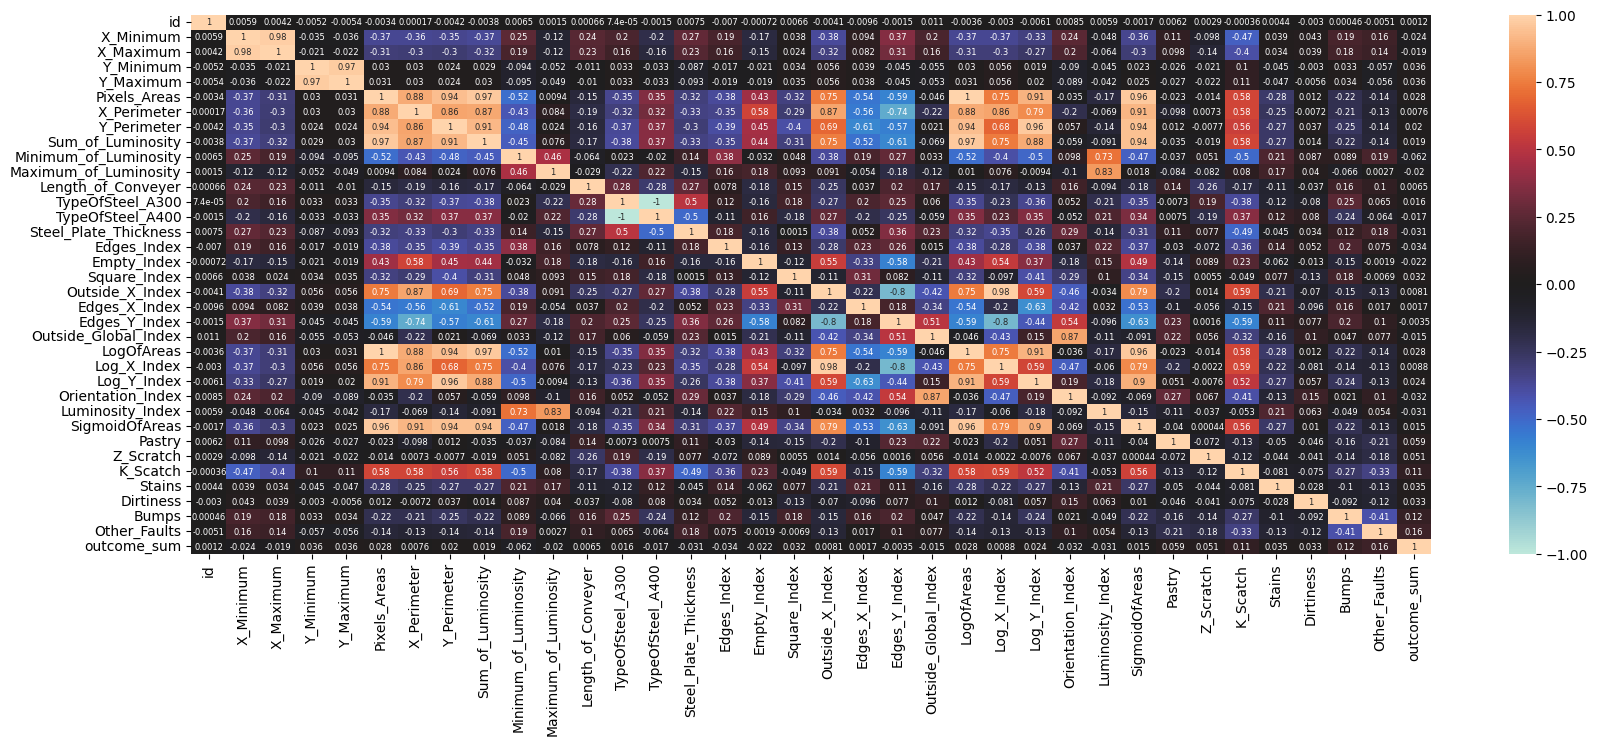

In [8]:
plt.figure(figsize=(20, 7))
sns.heatmap(train_df.loc[:].corr(method='spearman'),vmin=-1,vmax=1,center=0,annot=True, annot_kws={"fontsize": 6})

In [9]:
train_df_exp['new_variable'].value_counts()

new_variable
Other_Faults    6540
Bumps           4761
K_Scatch        3411
Pastry          1465
Z_Scratch       1150
None             818
Stains           568
Dirtiness        485
Mixed             21
Name: count, dtype: int64

In [10]:
EDA_feature_columns = ['X_Minimum', 'X_Maximum', 'X_delta', 'Y_Minimum', 'Y_Maximum', 'Y_delta', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 
                   'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 
                   'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 
                   'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 
                   'Luminosity_Index', 'SigmoidOfAreas', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index']

EDA_outcome_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'outcome_sum']

In [11]:
train_df['Length_of_Conveyer_squared'] = np.square(train_df['Length_of_Conveyer'])
test_df['Length_of_Conveyer_squared'] = np.square(test_df['Length_of_Conveyer'])

train_df['Length_of_Conveyer_bins'] = (train_df['Length_of_Conveyer'] >= 1500).astype(int)
test_df['Length_of_Conveyer_bins'] = (test_df['Length_of_Conveyer'] >= 1500).astype(int)

train_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,outcome_sum,Length_of_Conveyer_squared,Length_of_Conveyer_bins
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.00000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,128.647380,1459.350747,0.402674,0.596337,76.213122,0.352939,0.409309,0.574520,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225,0.958531,2.150894e+06,0.30345
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,14.196976,145.568687,0.490449,0.490644,53.931960,0.318976,0.124143,0.259436,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133,0.204786,4.430202e+05,0.45976
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,39.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.505529e+06,0.00000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.317500,0.375750,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.844164e+06,0.00000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413500,0.545400,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.860496e+06,0.00000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.656100,0.494600,0.818200,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.729104e+06,1.00000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.927500,1.000000,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.218436e+06,1.00000


In [12]:
train_df.shape

(19219, 38)

In [13]:
train_df = train_df[(train_df['outcome_sum'] == 1)]
train_df.reset_index(drop=True, inplace=True)

In [14]:
train_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,outcome_sum,Length_of_Conveyer_squared,Length_of_Conveyer_bins
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,1,1844164,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,1,2845969,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,1,1960000,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,1,1923769,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,1,2862864,1


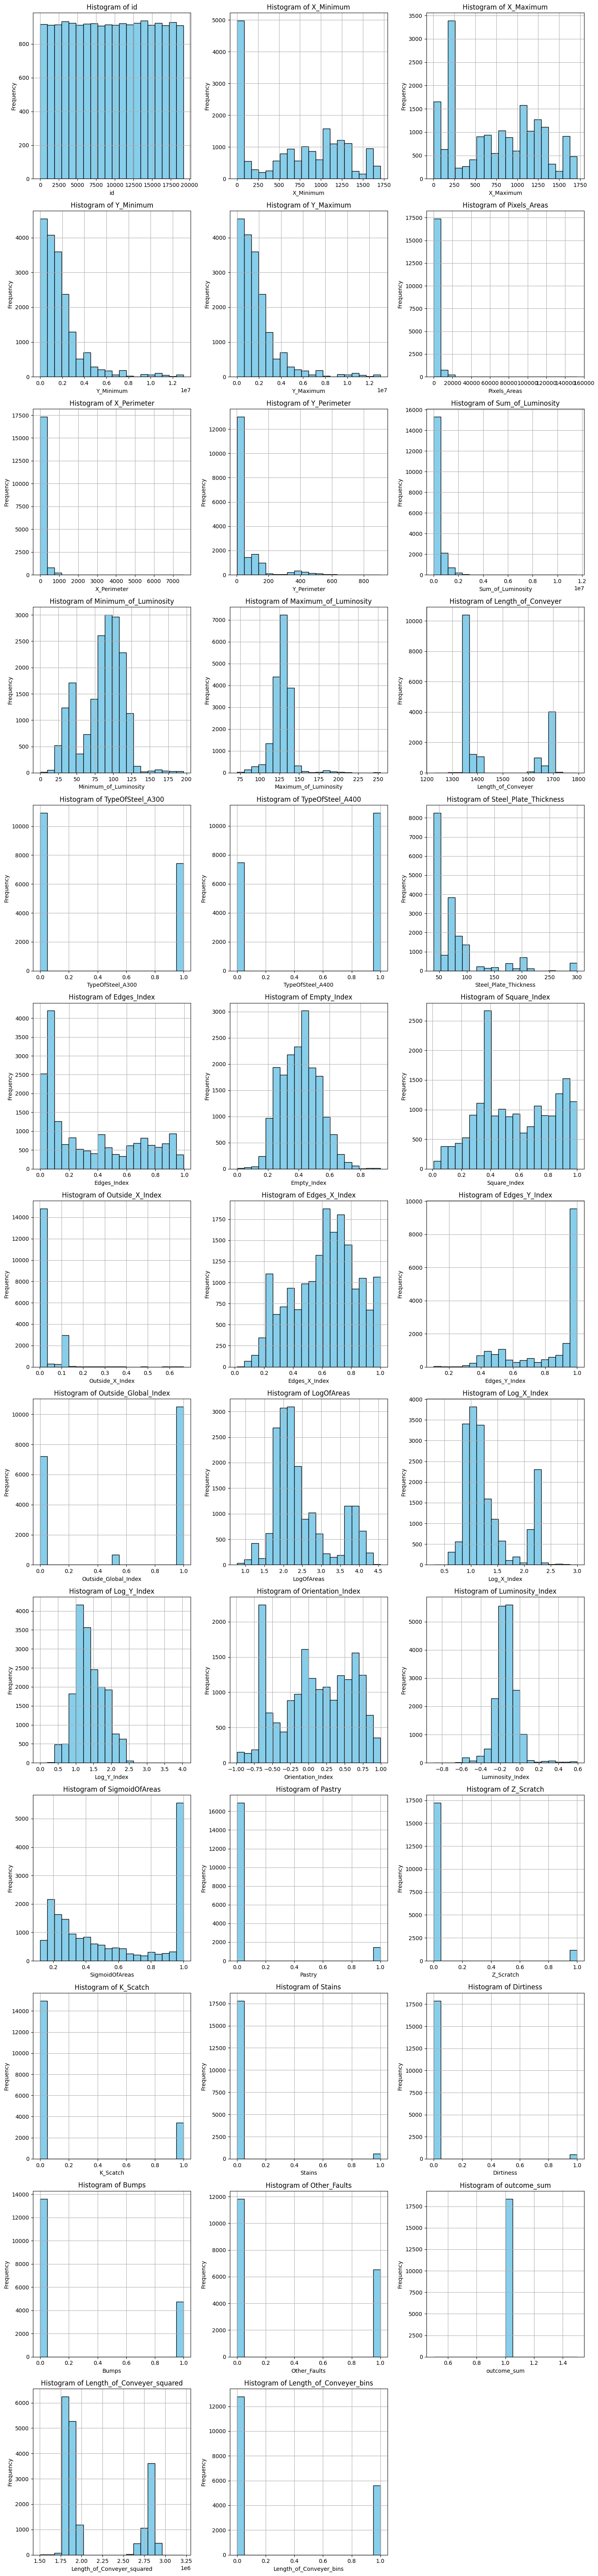

In [15]:
# Calculate the number of rows needed based on the number of columns
num_cols = len(train_df.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust the number 3 to change the number of histograms per row

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and plot a histogram
for i, column in enumerate(train_df.columns):
    ax = axes[i]
    ax.hist(train_df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')
    ax.grid(True)

# Hide any unused subplots
for j in range(i+1, num_rows*3):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [16]:
used_features_num = ['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Length_of_Conveyer',
       'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index',
       'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_Y_Index',
       'Orientation_Index', 'Luminosity_Index', 'Length_of_Conveyer_squared',
       'Length_of_Conveyer_bins']

used_features_cat = ['TypeOfSteel_A300', 'Outside_Global_Index']

In [17]:
X = train_df.drop(['id','TypeOfSteel_A400', 'SigmoidOfAreas', 'Y_Minimum', 'Y_Maximum', 'outcome_sum', 'Pastry', 'Z_Scratch', 'K_Scatch', 
                   'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'X_Perimeter', 'Y_Perimeter', 'Maximum_of_Luminosity', 'Log_X_Index'], axis=1)
y = train_df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

In [18]:
X.columns

Index(['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300',
       'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index',
       'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index',
       'Outside_Global_Index', 'LogOfAreas', 'Log_Y_Index',
       'Orientation_Index', 'Luminosity_Index', 'Length_of_Conveyer_squared',
       'Length_of_Conveyer_bins'],
      dtype='object')

In [19]:
y.columns

Index(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps',
       'Other_Faults'],
      dtype='object')

In [20]:
column_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

# Tensorflow Model

In [21]:
transformer_num = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, used_features_num),
    (transformer_cat, used_features_cat),
)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y.iloc[:,[0,6]])

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [22]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(7, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name="adam",
)

In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC'],
)

In [25]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=500,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)

Epoch 1/500
 50/460 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5680 - loss: 0.8988

I0000 00:00:1711894733.499683      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - AUC: 0.7081 - loss: 0.5859 - val_AUC: 0.9051 - val_loss: 0.2528
Epoch 2/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8803 - loss: 0.2771 - val_AUC: 0.9139 - val_loss: 0.2421
Epoch 3/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8934 - loss: 0.2632 - val_AUC: 0.9166 - val_loss: 0.2408
Epoch 4/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9012 - loss: 0.2541 - val_AUC: 0.9181 - val_loss: 0.2364
Epoch 5/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9042 - loss: 0.2510 - val_AUC: 0.9173 - val_loss: 0.2390
Epoch 6/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9038 - loss: 0.2511 - val_AUC: 0.9159 - val_loss: 0.2383
Epoch 7/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9055 - loss: 0.2496 - val_AUC: 0.9192 - val_loss: 0.2341
Epoch 8/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9079 - loss: 0.2474 - val_AUC: 0.9185 - val_loss: 0.2358
Epoch 9/500
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC

0.9231098294258118
0.9243640303611755


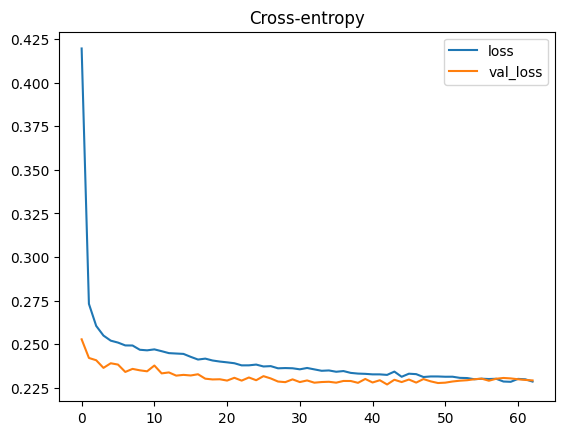

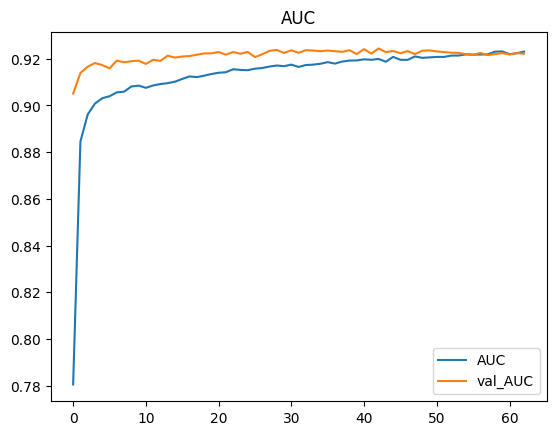

In [26]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['AUC', 'val_AUC']].plot(title="AUC")
print(history_df['AUC'].max())
print(history_df['val_AUC'].max())

In [27]:
X_test = preprocessor.transform(test_df)
print(X_test.shape)

(12814, 25)


In [28]:
preds = model.predict(X_test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [29]:
column_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

In [30]:
preds_df = pd.DataFrame(preds, columns = column_names)
preds_df.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.506263,0.001258,0.000549,0.000007,0.013091,0.152431,0.350545
1,0.232522,0.004703,0.001981,0.000125,0.174733,0.143856,0.405222
2,0.001187,0.054198,0.112103,0.003237,0.004581,0.319063,0.544312
3,0.053177,0.002962,0.000051,0.000151,0.011567,0.467835,0.454219
4,0.005758,0.003776,0.000092,0.000041,0.003664,0.621209,0.407042


In [31]:
# Extract 'id' column from train_df
id_column = test_df['id']

# Append id_column to preds_df
sub = pd.concat([id_column, preds_df], axis=1)

# XGB model

In [32]:
X_test_2= test_df.drop(['id','TypeOfSteel_A400', 'SigmoidOfAreas', 'Y_Minimum', 'Y_Maximum', 'X_Perimeter', 'Y_Perimeter', 'Maximum_of_Luminosity', 'Log_X_Index'], axis=1)
X_test_2.shape

(12814, 21)

In [33]:
X.shape

(18380, 21)

In [34]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y.iloc[:,[0,6]])

In [35]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [36]:
param_grid_1 = {
    'max_depth': [4],
    'learning_rate': [0.11],
    'n_estimators': [101],
    'gamma': [0.2],
    'subsample': [1.0],
    'colsample_bytree': [0.78],
    'colsample_bylevel': [0.53],
    'colsample_bynode' : [0.55],
    'min_child_weight' :[2],
    'reg_lambda': [1.01],
    'reg_alpha': [1.01],
    'max_bin' : [128],
    'max_leaves': [10],
    'sampling_method': ['uniform'],
    'num_parallel_tree': [20]
}

#Best parameters found: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 
#'max_bin': 128, 'max_depth': 4, 'max_leaves': 10, 'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 
#'sampling_method': 'uniform', 'subsample': 1.0}

In [37]:
xgb = XGBClassifier(device='cuda')

In [38]:
#grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_1, scoring='roc_auc', cv=3, verbose=2)
#grid_search.fit(X_train_2, y_train_2)

In [39]:
#best_params = grid_search.best_params_
#print("Best parameters found:", best_params)

#Best parameters found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
#Best parameters found: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
#Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 
#'n_estimators': 100, 'reg_lambda': 1.0, 'subsample': 1.0}

#Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_bin': 128, 'max_depth': 4, 'max_leaves': 5, 
#'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}

#Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_bin': 128, 'max_depth': 4, 'max_leaves': 10, 
#'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}

#Best parameters found: {'colsample_bylevel': 0.9, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 
#'max_bin': 128, 'max_depth': 4, 'max_leaves': 10, 'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}

#Best parameters found: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_bin': 128, 
#'max_depth': 4,'max_leaves': 10, 'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}

#Best parameters found: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 
#'max_bin': 128, 'max_depth': 4, 'max_leaves': 10, 'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}

#Best parameters found: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_bin': 128, 
#'max_depth': 4, 'max_leaves': 10, 'min_child_weight': 2, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'sampling_method': 'uniform', 'subsample': 1.0}

In [40]:
#best_model = grid_search.best_estimator_
#accuracy = best_model.score(X_valid_2, y_valid_2)
#print("Accuracy of the best model:", roc_auc_score)

In [41]:
#best_model

In [42]:
#XGBClassifier

model2 = XGBClassifier(
    max_depth=4,
    learning_rate=0.11,
    n_estimators=101,
    gamma=0.2,
    subsample=1.0,
    colsample_bytree=0.78,
    colsample_bylevel=0.53,
    colsample_bynode=0.55,
    min_child_weight=2,
    reg_lambda=1.01,
    reg_alpha=1.01,
    max_bin=128,
    max_leaves=10,
    sampling_method='uniform',
    tree_method='auto', 
    num_parallel_tree=20
)


In [43]:
print(X_train_2.columns)
X_valid_2.shape

Index(['X_Minimum', 'X_Maximum', 'Pixels_Areas', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300',
       'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index',
       'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index',
       'Outside_Global_Index', 'LogOfAreas', 'Log_Y_Index',
       'Orientation_Index', 'Luminosity_Index', 'Length_of_Conveyer_squared',
       'Length_of_Conveyer_bins'],
      dtype='object')


(3676, 21)

In [44]:
model2.fit(X_train_2, y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.53, colsample_bynode=0.55,
              colsample_bytree=0.78, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=128,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=10,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=101, n_jobs=None,
              num_parallel_tree=20, random_state=None, ...)

In [45]:
# Predictions
y_pred_2 = model2.predict_proba(X_test_2)

In [46]:
y_pred_val_2  = model2.predict_proba(X_valid_2)

In [47]:
threshold = 0.5

#Convert probabilities to 0s and 1s based on threshold
binary_matrix = (y_pred_val_2 > threshold).astype(int)

In [48]:
val_preds_df_2 = pd.DataFrame(binary_matrix, columns = column_names)
val_preds_df_2.value_counts(normalize=True)

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      0               0.391458
                   1         0       0          0      0               0.179815
                   0         0       0          0      1               0.171382
                                                1      0               0.151523
        1          0         0       0          0      0               0.047878
        0          0         1       0          0      0               0.036453
1       0          0         0       0          0      0               0.010881
0       0          0         0       0          1      1               0.004353
                                     1          0      0               0.004353
1       0          0         0       0          0      1               0.001088
0       0          1         0       0          0      1               0.000544
                   0         1       0          0   

In [49]:
preds_df_2 = pd.DataFrame(y_pred_2, columns = column_names)

In [50]:
# Calculate individual accuracies
acc_0_v1 = accuracy_score(y_valid_2.iloc[:, 0], val_preds_df_2.iloc[:, 0])
acc_1_v1 = accuracy_score(y_valid_2.iloc[:, 1], val_preds_df_2.iloc[:, 1])
acc_2_v1 = accuracy_score(y_valid_2.iloc[:, 2], val_preds_df_2.iloc[:, 2])
acc_3_v1 = accuracy_score(y_valid_2.iloc[:, 3], val_preds_df_2.iloc[:, 3])
acc_4_v1 = accuracy_score(y_valid_2.iloc[:, 4], val_preds_df_2.iloc[:, 4])
acc_5_v1 = accuracy_score(y_valid_2.iloc[:, 5], val_preds_df_2.iloc[:, 5])
acc_6_v1 = accuracy_score(y_valid_2.iloc[:, 6], val_preds_df_2.iloc[:, 6])

# Calculate average accuracy
average_acc_v1 = np.mean([acc_0_v1, acc_1_v1, acc_2_v1, acc_3_v1, acc_4_v1, acc_5_v1, acc_6_v1])


print('Pastry acc:', acc_0_v1)
print('Z_Scratch acc:',acc_1_v1)
print('K_Scatch acc:', acc_2_v1)
print('Stains acc:', acc_3_v1)
print('Dirtiness acc:', acc_4_v1)
print('Bumps acc:', acc_5_v1)
print('Other_Faults acc:', acc_6_v1)
print('Average acc:', average_acc_v1)    

#previous best submission
#Pastry acc: 0.9227367325702394
#K_Scatch acc: 0.9552549427679501
#K_Scatch acc: 0.9609781477627471
#Stains acc: 0.9828303850156087
#Dirtiness acc:  0.9742455775234131
#Bumps acc: 0.7791363163371487
#Other_Faults acc: 0.6795005202913632
#Overall AUC: 0.8954957633417572

Pastry acc: 0.9202937976060935
Z_Scratch acc: 0.9575625680087051
K_Scatch acc: 0.9651795429815017
Stains acc: 0.985854189336235
Dirtiness acc: 0.9755168661588683
Bumps acc: 0.7747551686615887
Other_Faults acc: 0.6841675734494015
Average acc: 0.8947613866003419


In [51]:
print(val_preds_df_2.value_counts(normalize=True))
print(train_df_exp['new_variable'].value_counts(normalize=True))

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      0               0.391458
                   1         0       0          0      0               0.179815
                   0         0       0          0      1               0.171382
                                                1      0               0.151523
        1          0         0       0          0      0               0.047878
        0          0         1       0          0      0               0.036453
1       0          0         0       0          0      0               0.010881
0       0          0         0       0          1      1               0.004353
                                     1          0      0               0.004353
1       0          0         0       0          0      1               0.001088
0       0          1         0       0          0      1               0.000544
                   0         1       0          0   

In [52]:
# Extract 'id' column from train_df
id_column = test_df['id']

sub_2 = pd.concat([id_column, preds_df_2], axis=1)

In [53]:
sub_2.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.514411,0.002140,0.004067,0.000153,0.010335,0.197672,0.409448
1,19220,0.251563,0.030005,0.013968,0.000260,0.166129,0.181185,0.333706
2,19221,0.001628,0.059031,0.040689,0.000536,0.008353,0.351238,0.526116
3,19222,0.124869,0.001424,0.000625,0.001610,0.016645,0.364535,0.486153
4,19223,0.002963,0.002293,0.001305,0.006781,0.007310,0.618377,0.400164


In [54]:
sub_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12814 entries, 0 to 12813
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            12814 non-null  int64  
 1   Pastry        12814 non-null  float32
 2   Z_Scratch     12814 non-null  float32
 3   K_Scatch      12814 non-null  float32
 4   Stains        12814 non-null  float32
 5   Dirtiness     12814 non-null  float32
 6   Bumps         12814 non-null  float32
 7   Other_Faults  12814 non-null  float32
dtypes: float32(7), int64(1)
memory usage: 450.6 KB


In [55]:
sub_2.to_csv('submission.csv', index=False)

# Merge subs

In [56]:
merged_preds = (preds_df + preds_df_2)/2

In [57]:
sub_final = pd.concat([id_column, merged_preds], axis=1)

In [58]:
sub_final.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.510337,0.001699,0.002308,0.000080,0.011713,0.175051,0.379996
1,19220,0.242042,0.017354,0.007974,0.000193,0.170431,0.162521,0.369464
2,19221,0.001408,0.056615,0.076396,0.001886,0.006467,0.335151,0.535214
3,19222,0.089023,0.002193,0.000338,0.000880,0.014106,0.416185,0.470186
4,19223,0.004361,0.003034,0.000698,0.003411,0.005487,0.619793,0.403603


In [59]:
sub_final.to_csv('submission.csv', index=False)